# Initialization

In [10]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import bs4
import requests
from collections import defaultdict
from functools import reduce
%matplotlib inline

file_opioids = 'opioids.csv'
file_overdoses = 'overdoses.csv'
file_prescribers = 'prescriber-info.csv'

# cosmetics for plots 
sns.set(font_scale = 1.5)

In [11]:
opioids = pd.read_csv(file_opioids)
overdoses = pd.read_csv(file_overdoses)
prescribers = pd.read_csv(file_prescribers)

### A few small cleaning tasks. 

In [12]:
overdoses = overdoses.set_index('State')
overdoses['Population']=overdoses['Population'].str.replace(',', '')
overdoses['Deaths']=overdoses['Deaths'].str.replace(',','')
overdoses[['Population', 'Deaths']]=overdoses[['Population','Deaths']].apply(pd.to_numeric)

# rename column because it's confusing
prescribers= prescribers.rename({'State':'Abbrev'}, axis=1);

# add prescriber information to overdose df 
prescribers_per_state = []
for index, row in overdoses.iterrows(): 
    prescribers_per_state.append(prescribers.loc[prescribers['Abbrev']==row['Abbrev']].shape[0])
overdoses['Prescribers'] = prescribers_per_state

# prescribers per capita
overdoses['Prescribers Per Capita'] = overdoses['Prescribers']/overdoses['Population']
overdoses['Prescribers Per 10,000'] = overdoses['Prescribers Per Capita'] * 10000
# overdoses per capita
overdoses['Deaths Per Capita'] = (overdoses['Deaths']/ overdoses['Population']) 
overdoses['Deaths Per 10,000'] = overdoses['Deaths Per Capita']*10000

# The Data Story

## Introduction: the dataset. 

## Questions 
1. Is the opioid overdose rate the same everywhere, or does it depend on the state? Are there US regions/divisions that are associated with a higher rate of overdose? 
2. Is the overdose rate related to the number of prescribers per capita? 
3. Which types of providers prescribe the most opioids? Why? 
4. Can we characterize provider specialties based on the drugs they prescribe in a year?

## Question 1: Is the opioid overdose rate the same everywhere, or does it depend on the state?

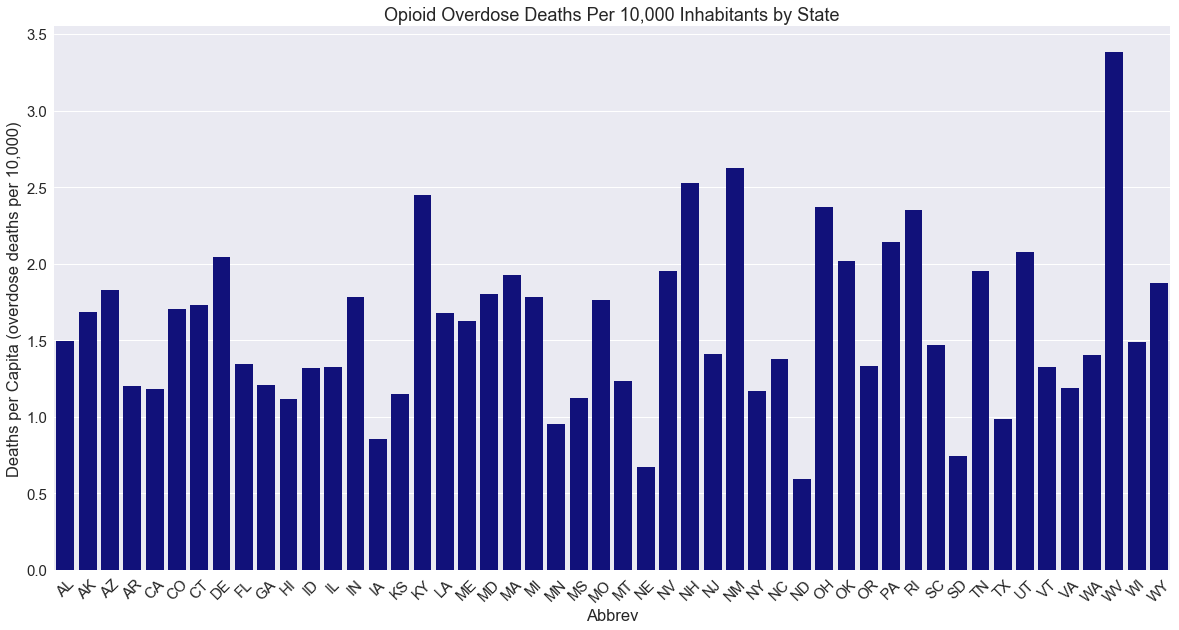

In [13]:
_ = plt.subplots(figsize=(20,10))
dpc_bar = sns.barplot(x = 'Abbrev', y='Deaths Per 10,000', data = overdoses, color = 'darkblue')
_ = dpc_bar.set_xticklabels(overdoses.Abbrev, rotation = 45)
_ = dpc_bar.set_ylabel('Deaths per Capita (overdose deaths per 10,000)')
_ = dpc_bar.set_title('Opioid Overdose Deaths Per 10,000 Inhabitants by State')

The above bar chart gives a good first overview of how the per capita death rate looks in different states, but it's hard to observe any geographical trends. 

In [8]:
overdoses.head()

,Population,Deaths,Abbrev,Prescribers,Prescribers Per Capita,Deaths Per Capita
State,,,,,,
Alabama,4833722,723,AL,344,0.000071,1.495742
Alaska,735132,124,AK,39,0.000053,1.686772
Arizona,6626624,1211,AZ,509,0.000077,1.827477
Arkansas,2959373,356,AR,216,0.000073,1.202958
California,38332521,4521,CA,2562,0.000067,1.179416


In [ ]:
0.594421
25%       1.203954
50%       1.490551
75%       1.912142
max       3.381323

In [32]:
overdoses['Deaths Per 10,000'].normalize()

AttributeError: 'Series' object has no attribute 'normalize'

State
Alabama           1.50
Alaska            1.69
Arizona           1.83
Arkansas          1.20
California        1.18
Colorado          1.71
Connecticut       1.73
Delaware          2.04
Florida           1.35
Georgia           1.21
Hawaii            1.12
Idaho             1.32
Illinois          1.32
Indiana           1.78
Iowa              0.85
Kansas            1.15
Kentucky          2.45
Louisiana         1.68
Maine             1.63
Maryland          1.80
Massachusetts     1.93
Michigan          1.78
Minnesota         0.95
Mississippi       1.12
Missouri          1.77
Montana           1.23
Nebraska          0.67
Nevada            1.95
New Hampshire     2.52
New Jersey        1.41
New Mexico        2.62
New York          1.17
North Carolina    1.38
North Dakota      0.59
Ohio              2.37
Oklahoma          2.02
Oregon            1.33
Pennsylvania      2.14
Rhode Island      2.35
South Carolina    1.47
South Dakota      0.75
Tennessee         1.95
Texas             0.98
Utah 

In [48]:
import plotly.plotly as py
import pandas as pd

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

overdoses['text'] = overdoses.index + '<br>' + 'Deaths Per 10,000:' + overdoses[
                    'Deaths Per 10,000'].map(lambda x: np.round(x,2)).astype(str) + '<br>' + 'Prescribers Per 10,000:' + overdoses[
                    'Prescribers Per 10,000'].map(lambda x: np.round(x,2)).astype(str)

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = overdoses['Abbrev'],
        z = overdoses['Deaths Per 10,000'],
        locationmode = 'USA-states',
        text = df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Per 10,000 Inhabitants")
        ) ]

layout = dict(
        title = '2013 US Opioid Overdose Rate Per 10,000 Inhabitants by State<br>(Hover for breakdown)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='opioid-overdoses-cloropleth-map' )

In [47]:
max_deaths = overdoses['Deaths'].max()
max_deaths_per_capita=overdoses['Deaths Per Capita'].max()
min_deaths_per_capita=overdoses['Deaths Per Capita'].min()
print('Max Deaths Per Capita')
print(overdoses.loc[overdoses['Deaths Per Capita']==max_deaths_per_capita])
print('-'*100)
print('Max Deaths')
print(overdoses.loc[overdoses['Deaths']==max_deaths])
print('-'*100)
print('Min Deaths Per Capita')
print(overdoses.loc[overdoses['Deaths Per Capita']==min_deaths_per_capita])
print('-'*100)
print('Descriptions')
print(overdoses['Deaths'].describe())
print(overdoses['Deaths Per Capita'].describe())

Max Deaths Per Capita
               Population  Deaths Abbrev  Prescribers  Prescribers Per Capita  \
State                                                                           
West Virginia     1854304     627     WV          199                0.000107   

               Prescribers Per 10,000  Deaths Per Capita  Deaths Per 10,000  \
State                                                                         
West Virginia                1.073179           0.000338           3.381323   

                                                            text  dp10_norm  
State                                                                        
West Virginia  West Virginia<br>Deaths Per 10,000:3.38<br>Pre...        1.0  
----------------------------------------------------------------------------------------------------
Max Deaths
            Population  Deaths Abbrev  Prescribers  Prescribers Per Capita  \
State                                                                   

In [43]:
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df['code'],
        z = overdoses['Deaths Per 10,000'],
        locationmode = 'USA-states',
        text = overdoses['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Per 10,000 Inhabitants")
        ) ]

layout = dict(
        title = '2013 US Opioid Overdoses by State<br>(Hover for breakdown)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='opioid-overdoses-cloropleth-map' )

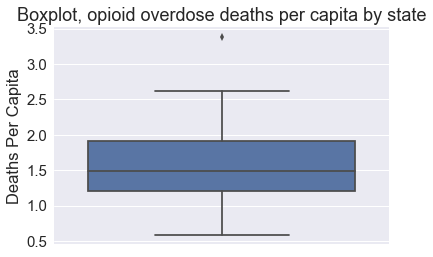

In [20]:
_ = sns.boxplot(y='Deaths Per Capita', data = overdoses)
_ = plt.title('Boxplot, opioid overdose deaths per capita by state')

In [36]:
df['total exports']

0      1390.63
1        13.31
2      1463.17
3      3586.02
4     16472.88
5      1851.33
6       259.62
7       282.19
8      3764.09
9      2860.84
10      401.84
11     2078.89
12     8709.48
13     5050.23
14    11273.76
15     4589.01
16     1889.15
17     1914.23
18      278.37
19      692.75
20      248.65
21     3164.16
22     7192.33
23      2170.8
24     3933.42
25      1718.0
26     7114.13
27      139.89
28       73.06
29       500.4
30      751.58
31      1488.9
32     3806.05
33     3761.96
34     3979.79
35     1646.41
36     1794.57
37     1969.87
38       31.59
39      929.93
40     3770.19
41     1535.13
42     6648.22
43      453.39
44      180.14
45     1146.48
46     3894.81
47      138.89
48     3090.23
49      349.69
Name: total exports, dtype: object

In [18]:
overdoses['Deaths Per Capita'].describe()

count    50.000000
mean      1.594367
std       0.546668
min       0.594421
25%       1.203954
50%       1.490551
75%       1.912142
max       3.381323
Name: Deaths Per Capita, dtype: float64

Deaths per capita range from .59 (North Dakota) to 3.38 (West Virginia). The median number of overdose deaths per capita is 1.49. How are states with higher overdose death rates related? 

Perhaps states within the same US Census region or division are 

In [22]:
url_gov = 'https://www2.census.gov/geo/docs/maps-data/maps/reg_div.txt'
regions_req = requests.get(url_gov)
soup_gov = bs4.BeautifulSoup(regions_req.content)
text=soup_gov.p
regions = text.contents[0].split('REGION')[1:]

reg_dict = defaultdict(list)
div_dict = defaultdict(list)
for row in regions: 
    row_by_div = [s for s in row.split('Division') if s!=''] # split on newlines, take out empty strings
    region_name = row_by_div[0].split(':')[1].strip().strip('*').title()
    div_list = [l.split('\r\n') for l in row_by_div[1:]]
    div_list = [[s for s in l if s!=''] for l in div_list]
    for div in div_list:
        division_name = div[0].split(':')[1].strip()
        reg_dict[region_name].append(division_name)
        for i in div[1:]:
            if i[0]=='*': # skip *Prior to June 1984..." line 
                break
            sep = '   '
            state = i.split(sep, 1)[0]
            div_dict[division_name].append(state)  
print(reg_dict)
print()
print(div_dict)

defaultdict(<class 'list'>, {'Northeast': ['New England', 'Middle Atlantic'], 'Midwest': ['East North Central', 'West North Central'], 'South': ['South Atlantic', 'East South Central', 'West South Central'], 'West': ['Mountain', 'Pacific']})

defaultdict(<class 'list'>, {'New England': ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont'], 'Middle Atlantic': ['New Jersey', 'New York', 'Pennsylvania'], 'East North Central': ['Illinois', 'Indiana', 'Michigan', 'Ohio', 'Wisconsin'], 'West North Central': ['Iowa', 'Kansas', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'South Dakota'], 'South Atlantic': ['Delaware', 'District of Columbia (11)', 'Florida', 'Georgia', 'Maryland', 'North Carolina  (37)', 'South Carolina  (45)', 'Virginia', 'West Virginia'], 'East South Central': ['Alabama', 'Kentucky', 'Mississippi', 'Tennessee'], 'West South Central': ['Arkansas', 'Louisiana', 'Oklahoma', 'Texas'], 'Mountain': ['Arizona', 'Colorado', 'Idaho', 'Montana',

In [6]:
tracked_drugs = list(prescribers.columns)[5:-1]

def provider_drugs(npi, df= prescribers, track_list = tracked_drugs):
    '''
    Given a provider NPI, returns a list of the drugs the provider prescribed
    Grabs this info from the prescribers database unless otherwise instructed, 
    Grabs info about which drugs are being tracked from tracked_drugs (built from prescribers)
    unless otherwise noted. 
    
    With track_list = detected_opioids, this returns the (recognized) opioids the provdier has prescribed! :)
    '''
    row = df[prescribers.NPI==npi]
    all_drugs = row[track_list].transpose()
    all_drugs.columns = ['num_prescriptions']
    return list(all_drugs.iloc[all_drugs.num_prescriptions.nonzero()].index)

prescribers['prescribed_drugs'] = prescribers['NPI'].apply(provider_drugs)

## Question 4: Can we characterize provider specialties based on the drugs they prescribe in a year?

In [7]:
def make_samples(val_list, col = 'Specialty', data_columns = tracked_drugs + ['Opioid.Prescriber'], 
                source_df = prescribers):
    '''
    INPUT: val_list, a list of values found in col 
           col, a string designating a column from source_df 
           data_columns, column names containing data we want in our sample
           source_df, the dataframe from which we're pulling data 
           
    '''
    samples = source_df[source_df[col].isin(val_list)][data_columns]
    return samples 

from sklearn.manifold import TSNE

In [8]:
# first try with two different prescribers...
from sklearn.manifold import TSNE
sample_drugs = prescribers[prescribers.Specialty.isin(['Optometry', 'Vascular Surgery'])]['prescribed_drugs']
sample_drugs = list(set([drug for sublist in sample_drugs for drug in sublist]))
samples = make_samples(['Optometry', 'Vascular Surgery'], data_columns = sample_drugs + ['Specialty'])
model = TSNE(learning_rate = 200)
transformed = model.fit_transform(samples[sample_drugs])
xs = transformed[:,0]
ys = transformed[:,1]

trans_df = pd.DataFrame(transformed, columns = ['x', 'y'])
trans_df = trans_df.reset_index(drop=True)
sample_labels = samples.Specialty.reset_index(drop=True)
trans_df= pd.concat([trans_df, sample_labels], axis=1)

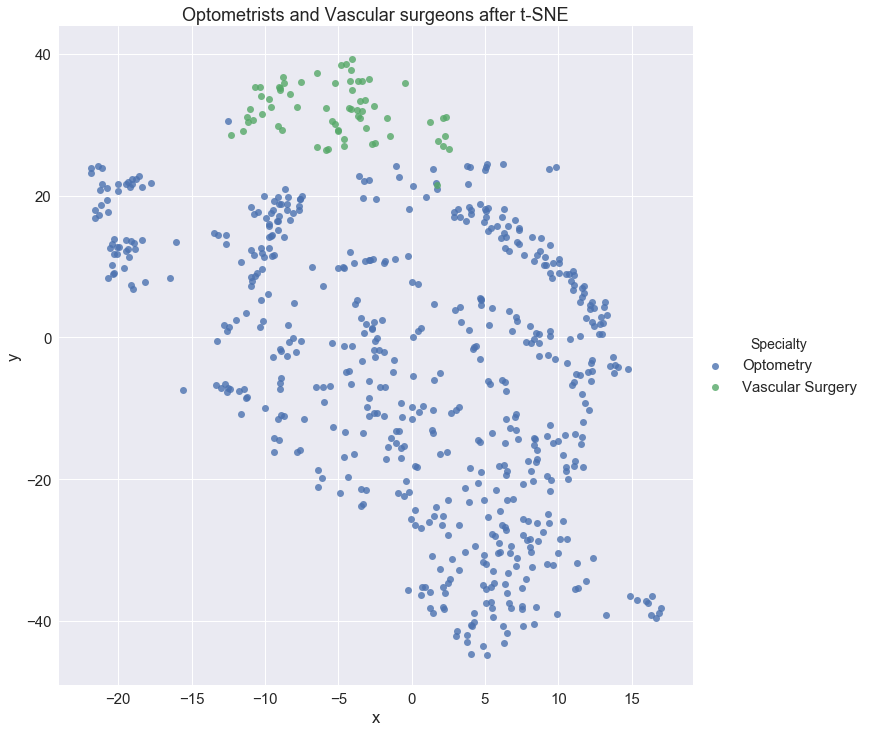

In [9]:
_ = sns.lmplot(x = 'x', y ='y', hue='Specialty', data=trans_df, fit_reg = 0, size=10, x_jitter=.5, y_jitter=.5)
_ = plt.title('Optometrists and Vascular surgeons after t-SNE')

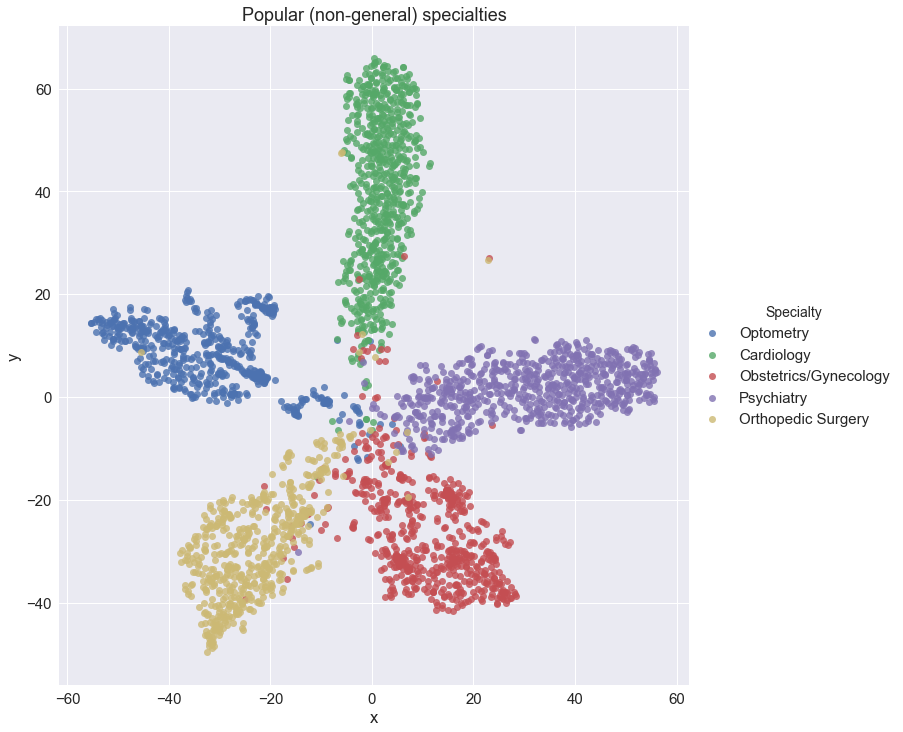

In [10]:
very_popular_specializations = ['Psychiatry', 'Cardiology', 'Obstetrics/Gynecology', 'Orthopedic Surgery', 'Optometry', 'Opthalmology']

samples_popular = make_samples(very_popular_specializations, data_columns = tracked_drugs + ['Specialty'])
model = TSNE(learning_rate = 500, perplexity=50)
transformed_popular = model.fit_transform(samples_popular[tracked_drugs])
xs = transformed_popular[:,0]
ys = transformed_popular[:,1]

trans_df_popular = pd.DataFrame(transformed_popular, columns = ['x', 'y'])
trans_df_popular = trans_df_popular.reset_index(drop=True)
sample_labels_popular = samples_popular.Specialty.reset_index(drop=True)
trans_df_popular= pd.concat([trans_df_popular, sample_labels_popular], axis=1)

_ = sns.lmplot(x = 'x', y ='y', hue='Specialty', data=trans_df_popular, fit_reg = 0, size=10, x_jitter=.5, y_jitter=.5)
_ = plt.title('Popular (non-general) specialties')

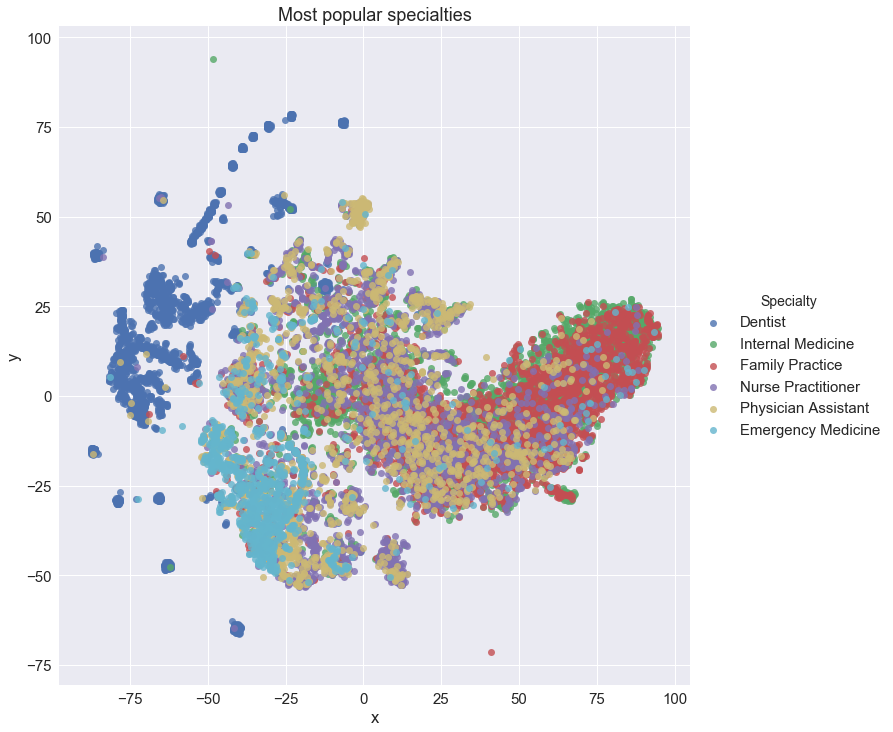

In [11]:
specialty_counts = prescribers.Specialty.value_counts()
most_popular = list(specialty_counts[specialty_counts > 1000].index)
samples = make_samples(most_popular, data_columns = tracked_drugs + ['Specialty'])
model = TSNE(learning_rate = 500, perplexity=50)
transformed = model.fit_transform(samples[tracked_drugs])
xs = transformed[:,0]
ys = transformed[:,1]

trans_df = pd.DataFrame(transformed, columns = ['x', 'y'])
trans_df = trans_df.reset_index(drop=True)
sample_labels = samples.Specialty.reset_index(drop=True)
trans_df= pd.concat([trans_df, sample_labels], axis=1)

_ = sns.lmplot(x = 'x', y ='y', hue='Specialty', data=trans_df, fit_reg = 0, size=10, x_jitter=.5, y_jitter=.5)
_ = plt.title('Most popular specialties')

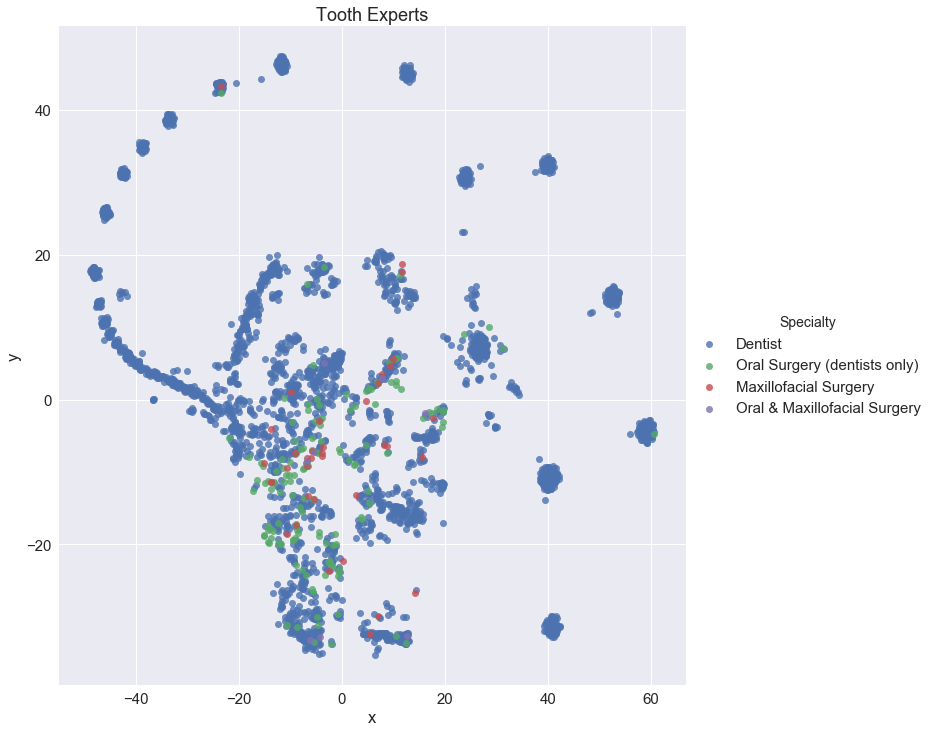

In [12]:
tooth_experts = ['Maxillofacial Surgery', 'Dentist', 'Oral & Maxillofacial Surgery','Oral Surgery (dentists only)']
tooth_samples = make_samples(tooth_experts, data_columns = tracked_drugs + ['Specialty'])
tooth_model = TSNE(learning_rate = 500, perplexity=30)
tooth_transformed = model.fit_transform(tooth_samples[tracked_drugs])
xs = tooth_transformed[:,0]
ys = tooth_transformed[:,1]

tooth_trans_df = pd.DataFrame(tooth_transformed, columns = ['x', 'y'])
tooth_trans_df = tooth_trans_df.reset_index(drop=True)
tooth_sample_labels = tooth_samples.Specialty.reset_index(drop=True)
tooth_trans_df= pd.concat([tooth_trans_df, tooth_sample_labels], axis=1)

_ = sns.lmplot(x = 'x', y ='y', hue='Specialty', data=tooth_trans_df, fit_reg = 0, size=10, x_jitter=.5, y_jitter=.5)
_ = plt.title('Tooth Experts')